# **Initialization**

In [1]:
!pip install selenium
from selenium import webdriver
!apt-get update
!apt install chromium-driver
def web_driver():
  options = webdriver.ChromeOptions()
  options.add_argument("--verbose")
  options.add_argument('--headless')
  options.add_argument('--no-sandbox')
  options.add_argument('--disable-gpu')
  options.add_argument('--disable-dev-shm-usage')
  driver = webdriver.Chrome(options=options)
  return driver
driver = web_driver()

Hit:1 https://cli.github.com/packages stable InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [3,794 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 4,051 kB in 1s (2,769 kB/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as 

# **Data Extraction**

In [2]:
def extract_car_data(car_text):
    """
    Extract car details from the text content.
    Returns a dictionary with the extracted data.
    """
    lines = car_text.strip().split('\n')

    data = {
        'Car_Name': '',
        'Year': '',
        'Kilometers_Driven': '',
        'Fuel_Type': '',
        'Transmission': '',
        'Price': ''
    }

    try:
        # Year and Car Name
        first_line = lines[0].strip()
        year_match = re.search(r'\b(19|20)\d{2}\b', first_line)
        if year_match:
            data['Year'] = year_match.group(0)
            data['Car_Name'] = first_line

        # Parse through other lines
        for line in lines[1:]:
            line = line.strip()

            # Kilometers driven
            if 'km' in line.lower() and ('k' in line.lower() or re.search(r'\d', line)):
                data['Kilometers_Driven'] = line

            # Fuel type
            elif any(fuel in line.lower() for fuel in ['petrol', 'diesel', 'cng', 'electric', 'hybrid']):
                data['Fuel_Type'] = line

            # Transmission
            elif any(trans in line.lower() for trans in ['manual', 'auto', 'automatic']):
                data['Transmission'] = line

            # Price
            elif 'lakh' in line.lower() and '₹' in line:
                # Extract the main price (e.g., "₹3.35 lakh")
                price_match = re.search(r'₹[\d.]+\s*lakh', line)
                if price_match:
                    data['Price'] = price_match.group(0)

    except Exception as e:
        print(f"Error parsing data: {e}")

    return data

# **Web Scrapping**

In [3]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.common.exceptions import InvalidSessionIdException
import time
import csv
import re
from datetime import datetime

try:
    # Fresh driver instance
    if 'driver' not in locals() or not driver.session_id:
        print("Creating a new WebDriver instance...")
        driver = web_driver()

    # Navigate to the website
    driver.get("https://www.cars24.com/buy-used-car/?f=make%3A%3D%3Ahyundai&search=hyundai&listingSource=Search_HP&storeCityId=2378")
    time.sleep(5)  # Wait for page to load completely

    # Scroll and click "Next" to load all cars
    print("Loading all car listings...")
    print(f"URL: {driver.current_url}\n")

    previous_count = 0
    no_change_iterations = 0
    max_iterations = 100  # Maximum scroll attempts
    iteration = 0

    while iteration < max_iterations:
        iteration += 1

        # Get current count of car elements
        current_elems = driver.find_elements(By.CLASS_NAME, "styles_outer__NTVth")
        current_count = len(current_elems)

        print(f"Iteration {iteration}: Found {current_count} cars")

        # Different scrolling methods
        # Scroll in increments
        for i in range(5):
            driver.execute_script("window.scrollBy(0, 300);")
            time.sleep(0.2)

        # Scroll to bottom
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(1)

        # Scrolling within specific containers
        try:
            containers = driver.find_elements(By.CSS_SELECTOR, "div[class*='container'], div[class*='list'], div[class*='grid']")
            for container in containers[:3]:  # Try first 3 containers
                driver.execute_script("arguments[0].scrollTop = arguments[0].scrollHeight", container)
        except:
            pass

        time.sleep(1)

        # Find and click the "Next" button or other likely load more buttons
        button_clicked = False
        button_selectors = [
            "//button[contains(translate(text(), 'ABCDEFGHIJKLMNOPQRSTUVWXYZ', 'abcdefghijklmnopqrstuvwxyz'), 'next')]",
            "//button[contains(translate(text(), 'ABCDEFGHIJKLMNOPQRSTUVWXYZ', 'abcdefghijklmnopqrstuvwxyz'), 'load more')]",
            "//a[contains(translate(text(), 'ABCDEFGHIJKLMNOPQRSTUVWXYZ', 'abcdefghijklmnopqrstuvwxyz'), 'next')]",
            "//a[contains(translate(text(), 'ABCDEFGHIJKLMNOPQRSTUVWXYZ', 'abcdefghijklmnopqrstuvwxyz'), 'load more')]",
            "//*[contains(@class, 'pagination')]//button",
            "//*[contains(@class, 'next')]",
        ]

        for selector in button_selectors:
            try:
                buttons = driver.find_elements(By.XPATH, selector)
                for button in buttons:
                    if button.is_displayed() and button.is_enabled():
                        try:
                            # Scroll to button
                            driver.execute_script("arguments[0].scrollIntoView({behavior: 'smooth', block: 'center'});", button)
                            time.sleep(0.5)
                            # Clicking
                            button.click()
                            print(f"  → Clicked button: {button.text[:50]}")
                            button_clicked = True
                            time.sleep(2)
                            break
                        except:
                            # JavaScript click
                            try:
                                driver.execute_script("arguments[0].click();", button)
                                print(f"  → JS-clicked button: {button.text[:50]}")
                                button_clicked = True
                                time.sleep(2)
                                break
                            except:
                                pass
                if button_clicked:
                    break
            except:
                continue

        time.sleep(1)

        # Check if new cars were loaded
        new_elems = driver.find_elements(By.CLASS_NAME, "styles_outer__NTVth")
        new_count = len(new_elems)

        if new_count > current_count:
            print(f"  ✓ Loaded {new_count - current_count} more cars (Total: {new_count})")
            no_change_iterations = 0
        else:
            no_change_iterations += 1
            print(f"  → No new cars loaded (attempt {no_change_iterations}/8)")

        # If no new content loaded for 8 consecutive iterations, stop
        if no_change_iterations >= 8:
            print("\n" + "="*60)
            print("No more cars to load. This appears to be all available cars.")
            print("="*60 + "\n")
            break

        previous_count = new_count

    print("Finished loading. Collecting all car listings...\n")

    # All car listing elements after loading everything
    elems = driver.find_elements(By.CLASS_NAME, "styles_outer__NTVth")

    print(f"Total cars found: {len(elems)}")
    print("Extracting data...\n")

    # Collect data from all elements
    all_cars_data = []

    for idx, elem in enumerate(elems, 1):
        try:
            # Get the text content of each car listing
            car_text = elem.text
            car_data = extract_car_data(car_text)
            all_cars_data.append(car_data)
            print(f"✓ Car #{idx}: {car_data['Car_Name']}")
        except Exception as e:
            print(f"✗ Error extracting Car #{idx}: {str(e)}")

except InvalidSessionIdException:
    print("Caught InvalidSessionIdException. The WebDriver session was lost.")
    print("Please try re-running the cells to create a new session.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


finally:
    # Close the browser if the driver object is still valid
    if 'driver' in locals() and driver.session_id:
        try:
            time.sleep(2)
            driver.close()
            print("\nBrowser closed.")
        except InvalidSessionIdException:
            print("\nWebDriver session already closed or invalid during cleanup.")
    else:
        print("\nNo active WebDriver session to close.")

Loading all car listings...
URL: https://www.cars24.com/buy-used-car/?f=make%3A%3D%3Ahyundai&search=hyundai&listingSource=Search_HP&storeCityId=2378

Iteration 1: Found 20 cars
  → Clicked button: Next
  ✓ Loaded 20 more cars (Total: 40)
Iteration 2: Found 40 cars
  → Clicked button: Next
  ✓ Loaded 20 more cars (Total: 60)
Iteration 3: Found 60 cars
  → Clicked button: Next
  → No new cars loaded (attempt 1/8)
Iteration 4: Found 60 cars
  → Clicked button: Next
  → No new cars loaded (attempt 2/8)
Iteration 5: Found 60 cars
  → Clicked button: Next
  ✓ Loaded 20 more cars (Total: 80)
Iteration 6: Found 80 cars
  → Clicked button: Next
  ✓ Loaded 20 more cars (Total: 100)
Iteration 7: Found 100 cars
  → Clicked button: Next
  ✓ Loaded 20 more cars (Total: 120)
Iteration 8: Found 120 cars
  → Clicked button: Next
  → No new cars loaded (attempt 1/8)
Iteration 9: Found 120 cars
  → Clicked button: Next
  ✓ Loaded 20 more cars (Total: 140)
Iteration 10: Found 140 cars
  → Clicked button: 

# **Saving Data**

In [4]:
if all_cars_data:
    csv_filename = 'Cars24_DataSet.csv'
    fieldnames = ['Car_Name', 'Year', 'Kilometers_Driven', 'Fuel_Type', 'Transmission', 'Price']

    with open(csv_filename, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(all_cars_data)

    print("Dataset saved successfully as 'Cars24_DataSet.csv'")
else:
    print("No data found to write to CSV")

Dataset saved successfully as 'Cars24_DataSet.csv'


# **Reading the CSV**

In [5]:
import pandas as pd

csv_file_path = 'Cars24_DataSet.csv'
try:
    df = pd.read_csv(csv_file_path)
    print(f"Successfully loaded '{csv_file_path}'")
    display(df)
except FileNotFoundError:
    print(f"Error: The file '{csv_file_path}' was not found.")
except Exception as e:
    print(f"An error occurred while reading the CSV file: {e}")

Successfully loaded 'Cars24_DataSet.csv'


,Car_Name,Year,Kilometers_Driven,Fuel_Type,Transmission,Price
0,2016 Hyundai Grand i10,2016,34.11k km,Petrol,Manual,₹3.35 lakh
1,2018 Hyundai Verna,2018,30.23k km,Petrol,Auto,₹6.68 lakh
2,2018 Hyundai Grand i10,2018,63.23k km,Petrol,Manual,₹3.50 lakh
3,2014 Hyundai Xcent,2014,96.90k km,Petrol,Manual,₹3.00 lakh
4,2020 Hyundai GRAND I10 NIOS,2020,40.15k km,Petrol,Auto,₹4.55 lakh
...,...,...,...,...,...,...
430,2015 Hyundai Xcent,2015,36.89k km,Petrol,Manual,₹3.00 lakh
431,2021 Hyundai NEW I20,2021,31.68k km,Petrol,Auto,₹7.31 lakh
432,2021 Hyundai GRAND I10 NIOS,2021,45.47k km,CNG,Manual,₹5.20 lakh
433,2017 Hyundai Creta,2017,49.97k km,Diesel,Manual,₹6.60 lakh


# **Processing DataSet**

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435 entries, 0 to 434
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Car_Name           435 non-null    object
 1   Year               435 non-null    int64 
 2   Kilometers_Driven  435 non-null    object
 3   Fuel_Type          435 non-null    object
 4   Transmission       435 non-null    object
 5   Price              435 non-null    object
dtypes: int64(1), object(5)
memory usage: 20.5+ KB


## **Cleaning the DataSet**

In [7]:
# Clean Car_Name by removing year prefix
df['Car_Name'] = df['Car_Name'].str.replace(r'^\d{4}\s+', '', regex=True)

print(df['Car_Name'])

0           Hyundai Grand i10
1               Hyundai Verna
2           Hyundai Grand i10
3               Hyundai Xcent
4      Hyundai GRAND I10 NIOS
                ...          
430             Hyundai Xcent
431           Hyundai NEW I20
432    Hyundai GRAND I10 NIOS
433             Hyundai Creta
434         Hyundai Elite i20
Name: Car_Name, Length: 435, dtype: object


In [8]:
import re

def clean_kilometers(value):
    value = str(value).replace(' km', '').strip()

    # Handle thousands (k or K)
    if re.search(r'[kK]', value):
        value = value.replace('k', '').replace('K', '')
        return float(value) * 1000

    # Handle lakhs (L or lakh)
    elif re.search(r'[lL]', value):
        value = value.replace('lakh', '').replace('Lakh', '').replace('L', '').replace('l', '')
        return float(value) * 100000

    # Handle plain numeric values
    else:
        return float(value)

# Apply to DataFrame
df['Kilometers_Driven'] = df['Kilometers_Driven'].apply(clean_kilometers).astype(int)

In [9]:
import re

def clean_price(value):
    value = str(value).strip()

    # Remove currency symbol and extra spaces
    value = value.replace('₹', '').replace(',', '').strip()

    # Handle lakh or Lakh (× 1,00,000)
    if re.search(r'[lL]akh', value):
        value = re.sub(r'[lL]akh', '', value).strip()
        return float(value) * 100000

    # Handle crore or Crore (× 1,00,00,000)
    elif re.search(r'[cC]rore', value):
        value = re.sub(r'[cC]rore', '', value).strip()
        return float(value) * 10000000

    # Handle plain numeric value
    else:
        return float(value)

# Apply the function
df['Price'] = df['Price'].apply(clean_price).astype(int)
# Rename column 'Price' to 'Price(INR)'
df.rename(columns={'Price': 'Price(INR)'}, inplace=True)

In [10]:
df

,Car_Name,Year,Kilometers_Driven,Fuel_Type,Transmission,Price(INR)
0,Hyundai Grand i10,2016,34110,Petrol,Manual,335000
1,Hyundai Verna,2018,30230,Petrol,Auto,668000
2,Hyundai Grand i10,2018,63230,Petrol,Manual,350000
3,Hyundai Xcent,2014,96900,Petrol,Manual,300000
4,Hyundai GRAND I10 NIOS,2020,40150,Petrol,Auto,455000
...,...,...,...,...,...,...
430,Hyundai Xcent,2015,36890,Petrol,Manual,300000
431,Hyundai NEW I20,2021,31680,Petrol,Auto,731000
432,Hyundai GRAND I10 NIOS,2021,45470,CNG,Manual,520000
433,Hyundai Creta,2017,49970,Diesel,Manual,660000


## **Saving the Refined DataSet**

In [11]:
# Save the cleaned DataFrame to a new CSV file
df.to_csv('Refined_Cars24_DataSet.csv', index=False)

print("Refined dataset saved successfully as 'Refined_Cars24_DataSet.csv'")

Refined dataset saved successfully as 'Refined_Cars24_DataSet.csv'


# **Analysis on Clean DataSet**

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435 entries, 0 to 434
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Car_Name           435 non-null    object
 1   Year               435 non-null    int64 
 2   Kilometers_Driven  435 non-null    int64 
 3   Fuel_Type          435 non-null    object
 4   Transmission       435 non-null    object
 5   Price(INR)         435 non-null    int64 
dtypes: int64(3), object(3)
memory usage: 20.5+ KB


In [13]:
df.describe()

,Year,Kilometers_Driven,Price(INR)
count,435.000000,4.350000e+02,4.350000e+02
mean,2016.234483,6.535006e+04,4.677195e+05
std,3.784544,7.645680e+04,2.867710e+05
min,2010.000000,1.510000e+03,8.900000e+04
25%,2013.000000,3.444000e+04,2.670000e+05
50%,2016.000000,5.810000e+04,3.720000e+05
75%,2019.000000,8.247500e+04,6.510000e+05
max,2025.000000,1.450000e+06,1.695000e+06


In [14]:
df.duplicated().sum()

np.int64(0)

In [15]:
df.isnull().sum()

,0
Car_Name,0
Year,0
Kilometers_Driven,0
Fuel_Type,0
Transmission,0
Price(INR),0


In [16]:
df.nunique()

,0
Car_Name,24
Year,16
Kilometers_Driven,375
Fuel_Type,3
Transmission,2
Price(INR),296


In [17]:
df.value_counts()

Car_Name            Year  Kilometers_Driven  Fuel_Type  Transmission  Price(INR)
Hyundai i20 Active  2018  17560              Petrol     Manual        650000        1
Hyundai ALCAZAR     2021  37330              Diesel     Auto          1662000       1
                          180000             Diesel     Auto          1237000       1
Hyundai i20         2013  33180              Petrol     Manual        287000        1
                          32560              Petrol     Manual        209000        1
                                                                                   ..
Hyundai AURA        2021  73240              Petrol     Manual        576000        1
                          56760              Petrol     Manual        490000        1
                          51010              CNG        Manual        518000        1
                          20610              Petrol     Manual        637000        1
                    2020  57700              Diesel     Auto          542000        1
Name: count, Length: 435, dtype: int64

Car Age

In [18]:
current_year = 2025
current_year - df['Year']

,Year
0,9
1,7
2,7
3,11
4,5
...,...
430,10
431,4
432,4
433,8


Price per Kilometer

In [19]:
df['Price(INR)'] / df['Kilometers_Driven']

,0
0,9.821167
1,22.097254
2,5.535347
3,3.095975
4,11.332503
...,...
430,8.132285
431,23.074495
432,11.436112
433,13.207925


# **Visualization**

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid", palette="muted")
df = pd.read_csv("Refined_Cars24_DataSet.csv")

 1. Distribution of Car Prices

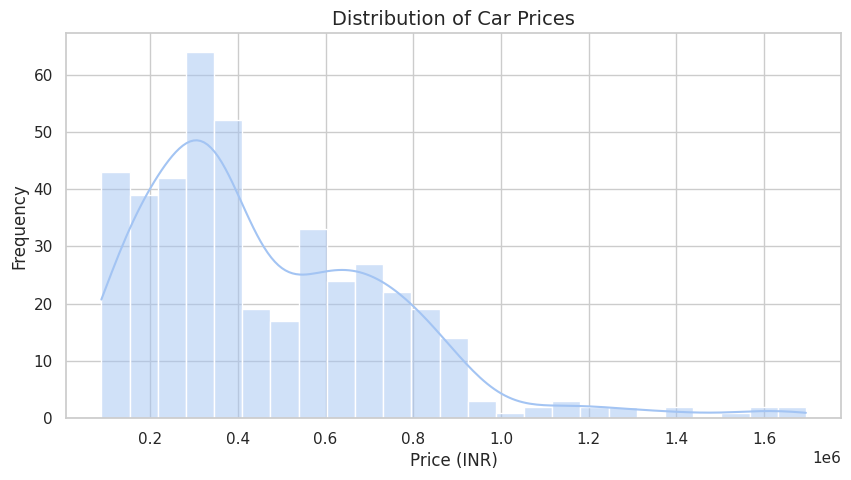

In [21]:
plt.figure(figsize=(10,5))
sns.histplot(df['Price(INR)'], bins=25, kde=True, color='#A3C4F3')
plt.title("Distribution of Car Prices", fontsize=14)
plt.xlabel("Price (INR)")
plt.ylabel("Frequency")
plt.show()

 2. Count of Cars by Fuel Type

/tmp/ipython-input-2583295100.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Fuel_Type', palette='pastel')


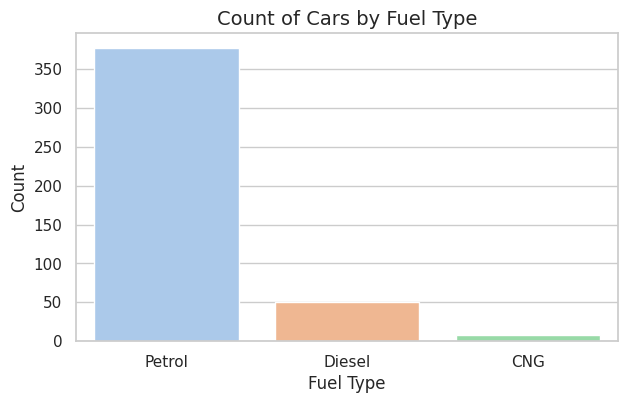

In [22]:
plt.figure(figsize=(7,4))
sns.countplot(data=df, x='Fuel_Type', palette='pastel')
plt.title("Count of Cars by Fuel Type", fontsize=14)
plt.xlabel("Fuel Type")
plt.ylabel("Count")
plt.show()

3. Count of Cars by Transmission Type

/tmp/ipython-input-2295498964.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Transmission', palette='Set3')


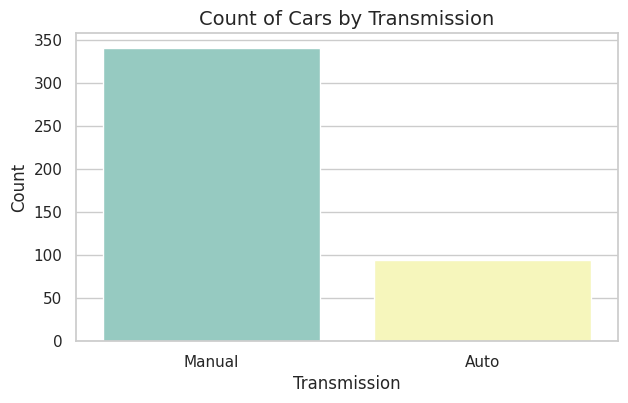

In [23]:
plt.figure(figsize=(7,4))
sns.countplot(data=df, x='Transmission', palette='Set3')
plt.title("Count of Cars by Transmission", fontsize=14)
plt.xlabel("Transmission")
plt.ylabel("Count")
plt.show()

 4. Average Price by Fuel Type

/tmp/ipython-input-1516011282.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='Fuel_Type', y='Price(INR)', estimator='mean', ci=None, palette='coolwarm')
/tmp/ipython-input-1516011282.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Fuel_Type', y='Price(INR)', estimator='mean', ci=None, palette='coolwarm')


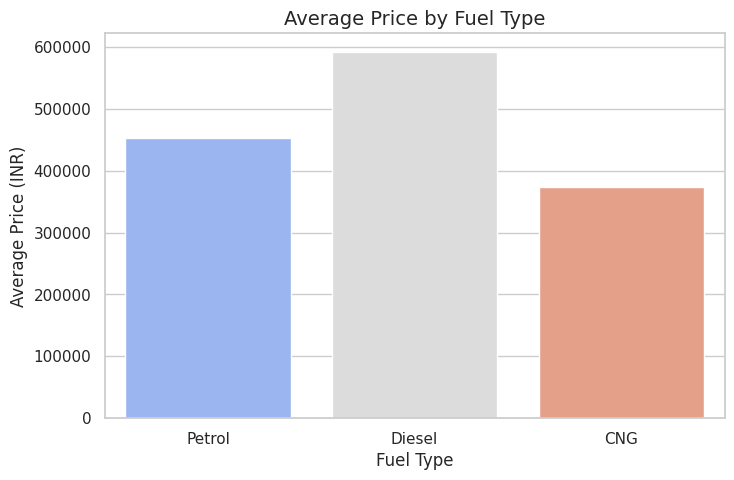

In [24]:
plt.figure(figsize=(8,5))
sns.barplot(data=df, x='Fuel_Type', y='Price(INR)', estimator='mean', ci=None, palette='coolwarm')
plt.title("Average Price by Fuel Type", fontsize=14)
plt.xlabel("Fuel Type")
plt.ylabel("Average Price (INR)")
plt.show()

5. Boxplot of Car Prices by Year

/tmp/ipython-input-3098063449.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Year', y='Price(INR)', palette='GnBu')


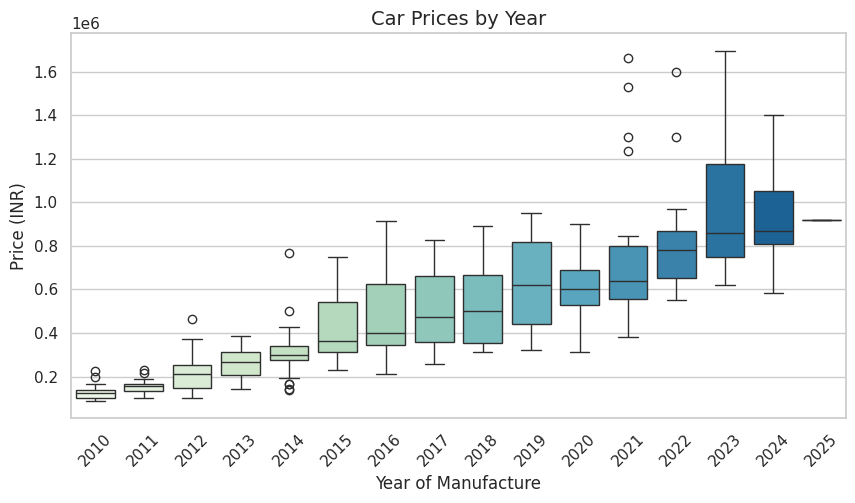

In [25]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df, x='Year', y='Price(INR)', palette='GnBu')
plt.title("Car Prices by Year", fontsize=14)
plt.xlabel("Year of Manufacture")
plt.ylabel("Price (INR)")
plt.xticks(rotation=45)
plt.show()

6. Scatter Plot - Kilometers Driven vs Price

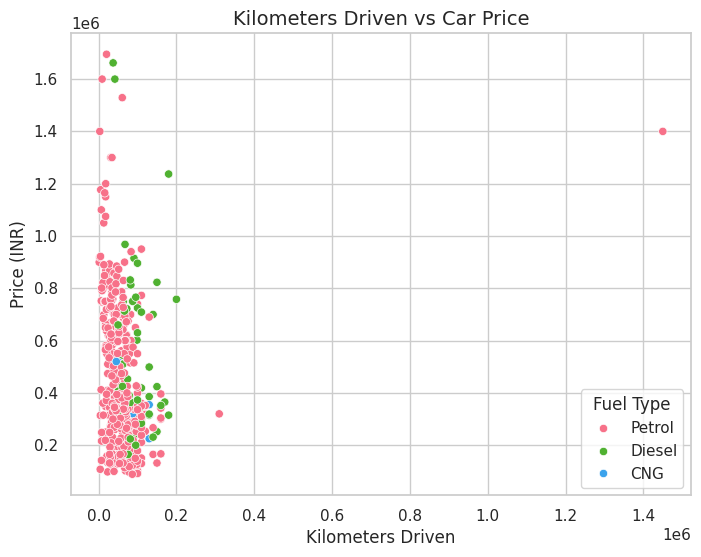

In [26]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='Kilometers_Driven', y='Price(INR)', hue='Fuel_Type', palette='husl')
plt.title("Kilometers Driven vs Car Price", fontsize=14)
plt.xlabel("Kilometers Driven")
plt.ylabel("Price (INR)")
plt.legend(title="Fuel Type")
plt.show()

7. Heatmap of Correlations

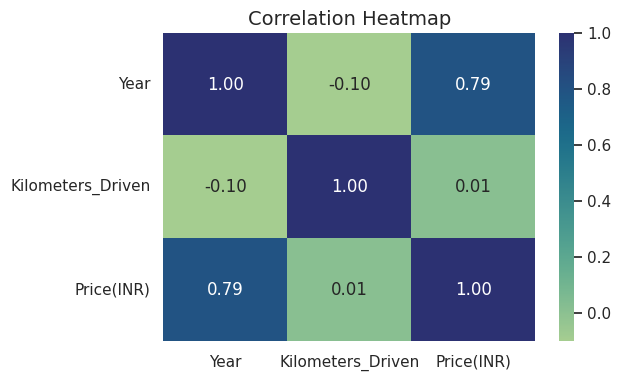

In [27]:
plt.figure(figsize=(6,4))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='crest', fmt='.2f')
plt.title("Correlation Heatmap", fontsize=14)
plt.show()

 8. Top 10 Most Common Car Models

/tmp/ipython-input-3321211780.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_models.index, y=top_models.values, palette='Spectral')


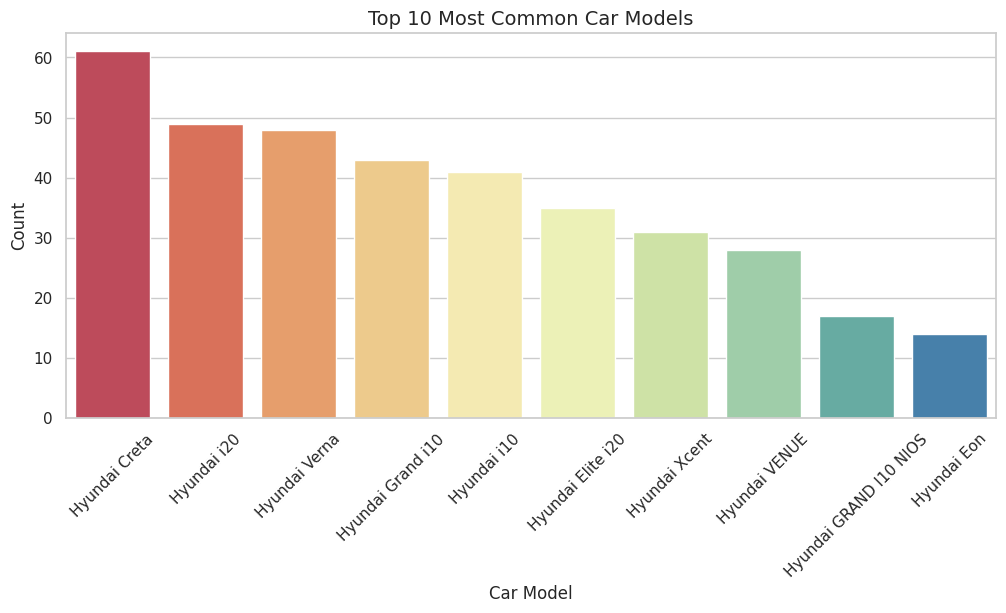

In [28]:
plt.figure(figsize=(12,5))
top_models = df['Car_Name'].value_counts().head(10)
sns.barplot(x=top_models.index, y=top_models.values, palette='Spectral')
plt.title("Top 10 Most Common Car Models", fontsize=14)
plt.xlabel("Car Model")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

9. Pairplot to Explore Relationships

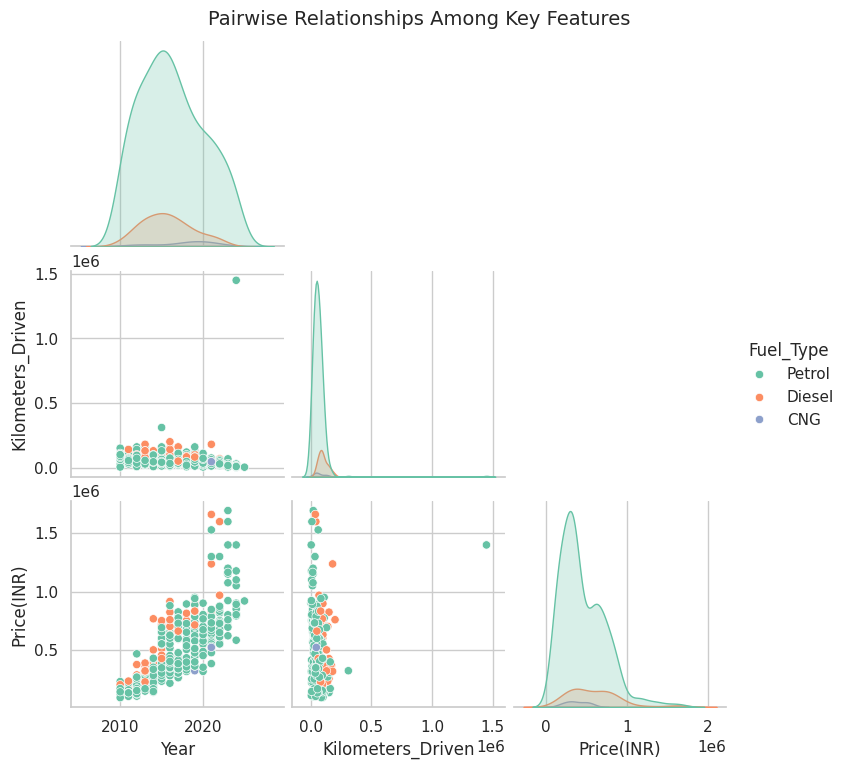

In [29]:
sns.pairplot(df, vars=['Year', 'Kilometers_Driven', 'Price(INR)'], hue='Fuel_Type', palette='Set2', corner=True)
plt.suptitle("Pairwise Relationships Among Key Features", y=1.02, fontsize=14)
plt.show()